# Hough Transform
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.transform import hough_line, hough_line_peaks
import cv2
%matplotlib inline

In [2]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    plt.show()

## Open Image
UFPR.jpg <br>
lines.png <br>
wave.jpg 

(708, 1280)


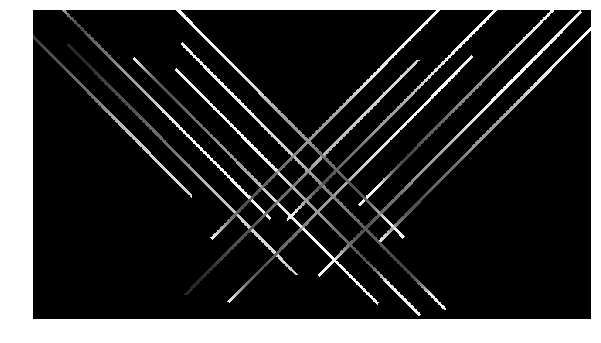

In [3]:
im_gray = cv2.imread('imgs/lines.png',cv2.IMREAD_GRAYSCALE)
print(im_gray.shape)
imshow(im_gray)

## Gradient Image

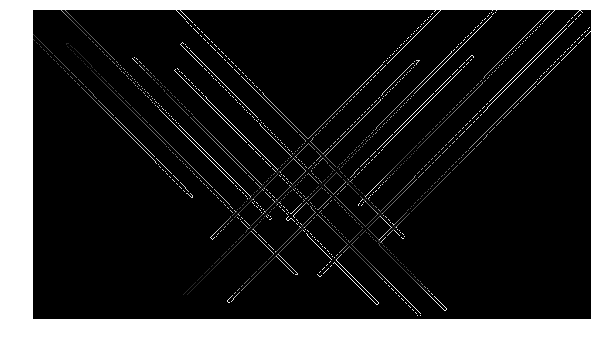

In [4]:
im_grad = gradient(im_gray, disk(1))
imshow(im_grad)

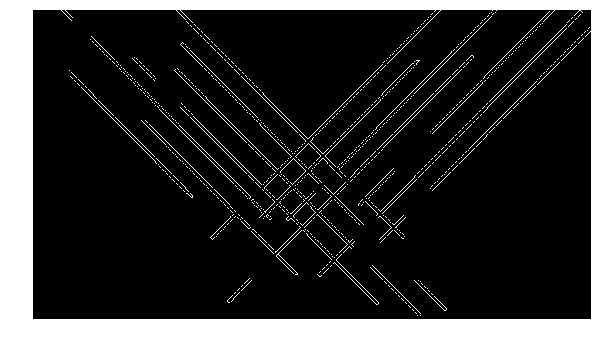

In [5]:
# Otsu's thresholding 
ret3,im_bin = cv2.threshold(im_grad,0,255,cv2.THRESH_OTSU)
imshow(im_bin)

## Hough Transform
$r = xcos(\theta)+ysin(\theta)$ <br>
$r \in \left[-\sqrt{M^2+N^2},\sqrt{M^2+N^2}\right]$<br>
$\theta \in \left[ -\dfrac{\pi}{2},\dfrac{\pi}{2}\right]$ <br>

In [6]:
y_max, x_max = im_bin.shape

r_steps = 2000
r_max = np.sqrt(y_max**2+x_max**2)
r_min = -r_max
#r_steps = np.ceil(r_max-r_min).astype('int')
r_step = (r_max-r_min)/(r_steps-1)
r_list = np.arange(r_min,r_max+r_step,r_step)
if r_list.shape[0]!=r_steps:
    r_list = r_list[:-1]

o_steps = 2000
o_max = -np.pi/2
o_min = -o_max
o_step = (o_max-o_min)/(o_steps-1)
o_list = np.arange(o_min,o_max+o_step,o_step)
if o_list.shape[0]!=o_steps:
    o_list = o_list[:-1]

r_steps,o_list.shape

(2000, (2000,))

In [7]:
%%time
im_hough = np.zeros((r_steps,o_steps))
for y in range(im_bin.shape[0]):
    for x in range(im_bin.shape[1]):
        if im_bin[y,x]:
            r_o_list = x*np.cos(o_list)+y*np.sin(o_list)
            r = np.round((r_o_list-r_min)/r_step).astype('int')
            im_hough[r,range(o_steps)]+=1
            

CPU times: user 15.8 s, sys: 24.1 ms, total: 15.8 s
Wall time: 15.8 s


(2000, 2000)


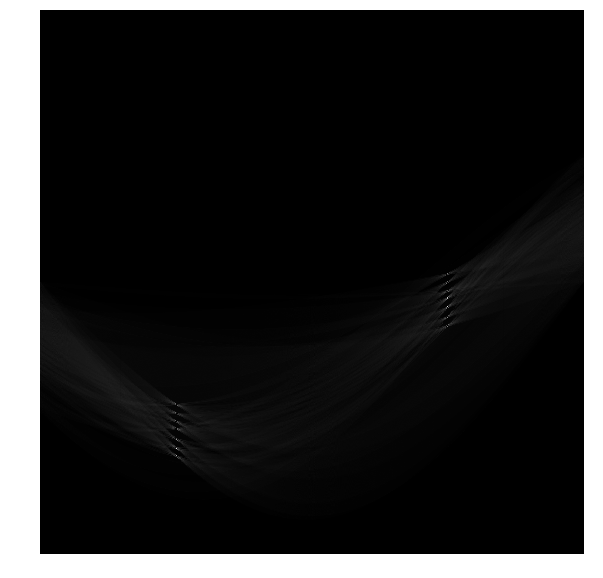

In [8]:
print(im_hough.shape)
imshow(im_hough)

## Plot lines

In [9]:
def plot_lines(im_gray,dists,angles,linewidth=0.7):
    pts1 = np.around(dists/np.sin(angles))                        #x=0     => [0,r/sin(o)]
    pts2 = np.around((dists-x_max*np.cos(angles))/np.sin(angles)) #x=x_max => [x_max,(r-x_max.cos(o))/sin(o)]
    
    #plot img
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(im_gray, cmap='gray')
    
    #plot lines
    for pt1,pt2 in zip(pts1,pts2):
        #plt.plot(x,y)
        plt.plot((0, x_max), (pt1, pt2), 'r',linewidth=linewidth)

    # [xmin, xmax, ymin, ymax]
    plt.axis((0,x_max,y_max,0))
    
    plt.show()

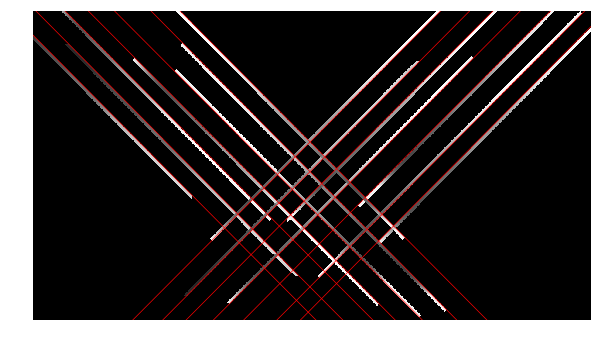

In [10]:
_, angles, dists = hough_line_peaks(im_hough, o_list, r_list)
plot_lines(im_gray,dists,angles)

## Skimage

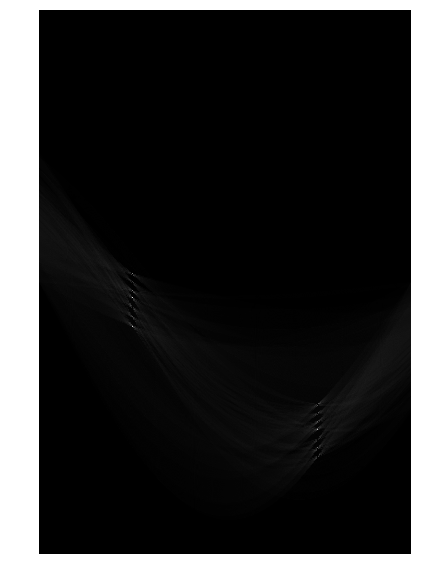

CPU times: user 743 ms, sys: 247 ms, total: 990 ms
Wall time: 735 ms


In [11]:
%%time
h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/2000))
imshow(h)

Peaks or Lines: 14


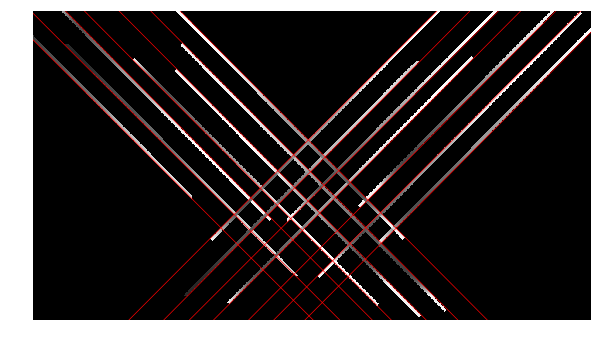

In [12]:
_, angles, dists = hough_line_peaks(h, theta, d)
print('Peaks or Lines:',len(angles))
plot_lines(im_gray,dists,angles)

## Find Lines 1
Simple Threshold <br>
Threshold = $\alpha(max-min)$

In [13]:
def hough_peaks1(im_hough, o_list, r_list, alpha=0.5):
    
    #mask create
    threshold = (im_hough.max()-im_hough.min())*alpha
    mask_peaks = im_hough>threshold
    
    #find all lines
    angles = list()
    dists = list()
    peaks = list()
    for r in range(mask_peaks.shape[0]):
        for o in range(mask_peaks.shape[1]):
            if mask_peaks[r][o]:
                angles.append(o_list[o])
                dists.append(r_list[r])
                peaks.append(im_hough[r][o])
    
    #to numpy
    angles = np.array(angles)
    dists = np.array(dists) 
    peaks = np.array(peaks) 
    
    print('Threshold:',threshold,'Peaks or Lines:',len(peaks))
    
    return peaks,angles,dists

Threshold: 471.5 Peaks or Lines: 123


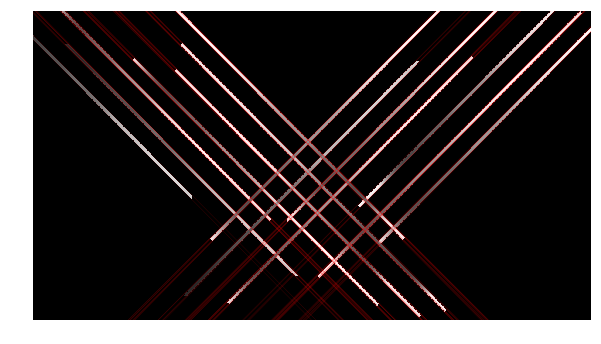

CPU times: user 1.75 s, sys: 160 ms, total: 1.91 s
Wall time: 1.68 s


In [14]:
%%time
_,angles,dists = hough_peaks1(im_hough, o_list, r_list)
plot_lines(im_gray,dists,angles,0.1)

## Find Lines 2
Simple Threshold <br>
$\downarrow$  <br>
Graph by Euclidean Distances of the peaks <br>
$\downarrow$  <br>
Component Connection <br>
$\downarrow$  <br>
Lines by weighted arithmetic mean 

In [15]:
alpha = 0.4 # Threshold [0,1[
beta = 2 #maximum distance of connected peaks (in pixels)

In [16]:
peaks,angles,dists = hough_peaks1(im_hough, o_list, r_list,alpha=alpha)

Threshold: 377.20000000000005 Peaks or Lines: 205


### My codes:

In [17]:
from collections import deque

#### Create Graph by Euclidean Distances
adjacency lists

In [18]:
%%time

adjacency_lists = list()

for i in range(len(peaks)):
    #Euclidean distances between point i and all points before i
    x1 = angles[i]
    x2 = angles#[i+1:]
    y1 = dists[i]
    y2 = dists#[i+1:]
    euclid_dist = (x2-x1)**2+(y2-y1)**2
    # very slow function
    #euclid_dist = euclidean_distances([[x1,y1]],zip(x2,y2))[0]
    
    #find edges
    edges = euclid_dist<(beta**2)
    edges = np.arange(edges.shape[0])[edges]
    #edges += i+1
    #edges = [(i,j) for j in edges]

    #save edges
    adjacency_lists.append(edges.astype('int32'))
    #edges_list = np.append(edges_list,np.array(edges))
    #edges_list += list(edges)

    #print
    if i%10000==0:
        print(i,'/',len(peaks))

print("to numpy ...")
adjacency_lists = np.array(adjacency_lists)
print(adjacency_lists.shape)

0 / 205
to numpy ...
(205,)
CPU times: user 7.04 ms, sys: 4.22 ms, total: 11.3 ms
Wall time: 8.93 ms


__Component Connection:__

In [19]:
%%time

visited = np.zeros(len(peaks))
n_class = 0

for v in range(len(peaks)):
    if visited[v]:
        continue
    
    #new class or component
    n_class += 1
    visited[v] = n_class
    
    #stack of vertices to look
    stack = deque()
    stack.append(v)
    
    while stack:
        #new vertice
        v = stack.pop()
        
        #add all neighbors not visited
        for neighbor in adjacency_lists[v]:
            
            if not visited[neighbor]:
                stack.append(neighbor)
                visited[neighbor] = n_class
                
print(n_class,'class')

23 class
CPU times: user 0 ns, sys: 2.29 ms, total: 2.29 ms
Wall time: 2.13 ms


__Creating Lines:__
weighted arithmetic mean 

In [20]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()

for c in range(n_class):
    
    #class mask
    mask = visited==(c+1)
    print(mask.sum(), 'peaks')
    
    #component connection points
    cc_angles = angles[mask]
    cc_dists = dists[mask]
    cc_peaks = peaks[mask]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

4 peaks
4 peaks
4 peaks
6 peaks
7 peaks
7 peaks
14 peaks
17 peaks
8 peaks
9 peaks
14 peaks
9 peaks
9 peaks
6 peaks
7 peaks
15 peaks
9 peaks
9 peaks
13 peaks
8 peaks
10 peaks
8 peaks
8 peaks


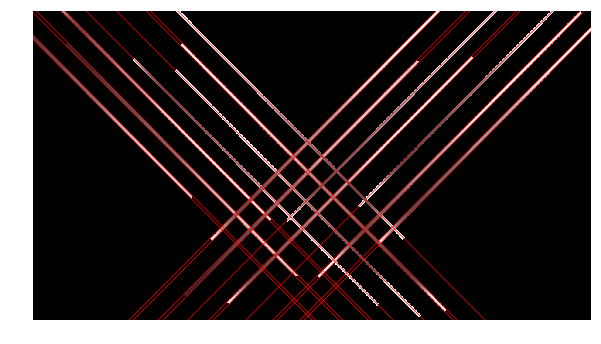

In [21]:
plot_lines(im_gray,avg_dists,avg_angles)

### With Libraries

In [22]:
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx

__Euclidean Distance Matrix:__

In [23]:
pts = list(zip(angles,dists))
euclidean_matrix = euclidean_distances(pts)

__Create Graph:__

In [24]:
adj_matrix = euclidean_matrix<beta
G = nx.from_numpy_matrix(adj_matrix)

CPU times: user 160 ms, sys: 15.7 ms, total: 176 ms
Wall time: 137 ms


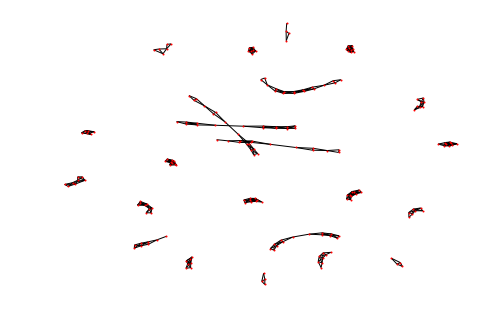

In [25]:
%%time
nx.draw(G,node_size=1)

__Connected Components:__

In [26]:
connected_components = nx.connected_components(G)
connected_components = sorted(nx.connected_components(G), key = len, reverse=True)
len(connected_components)

23

__Creating Lines:__ <br>
weighted arithmetic mean 

In [27]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()
for cc in connected_components:
    
    #points in components
    cc = list(cc)
    cc_angles = angles[cc]
    cc_dists = dists[cc]
    cc_peaks = peaks[cc]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

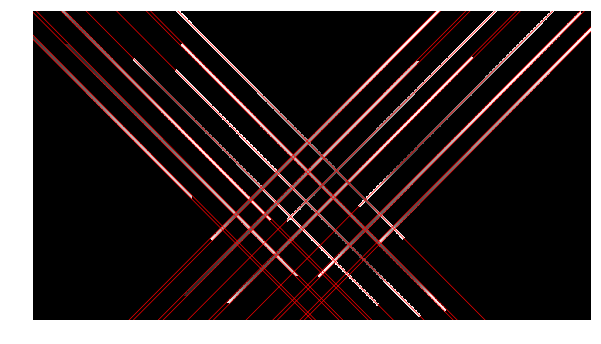

In [28]:
plot_lines(im_gray,avg_dists,avg_angles)

## Find Lines 3

In [68]:
def func_conv(im_hough, function, ksize=(5,5), strides=(1,1), *args):
    
    #only odd numbers
    if not (ksize[0]%2 and ksize[1]%2):
        return
    
    #sizes
    border = np.array([int(ksize[0]/2),int(ksize[1]/2)])
    h_size = im_hough.shape
    
    #border image
    im_border = np.zeros(h_size+2*border)
    im_border[border[0]:h_size[0]+border[0],border[1]:h_size[1]+border[1]] = im_hough
    
    #convolution function
    im_out = list()
    for i in range(0,h_size[0],strides[0]):
        line = list()
        for j in range(0,h_size[1],strides[1]):
            
            im_cut = im_border[i:i+ksize[0],j:j+ksize[1]]
            pixel = function(im_cut,*args)
            
            line.append(pixel)
        im_out.append(line)
    
    #return 
    im_out = np.array(im_out).astype('float32')
    
    return im_out

### 3.1 -  Kernel 1 (Averaging)

$K = \dfrac{1}{25} \begin{bmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \end{bmatrix}$

In [34]:
def func_kernel1(im):
    
    n = im.shape[0]*im.shape[1]
    kernel = np.ones(im.shape)
    
    return np.sum(im*kernel)/n

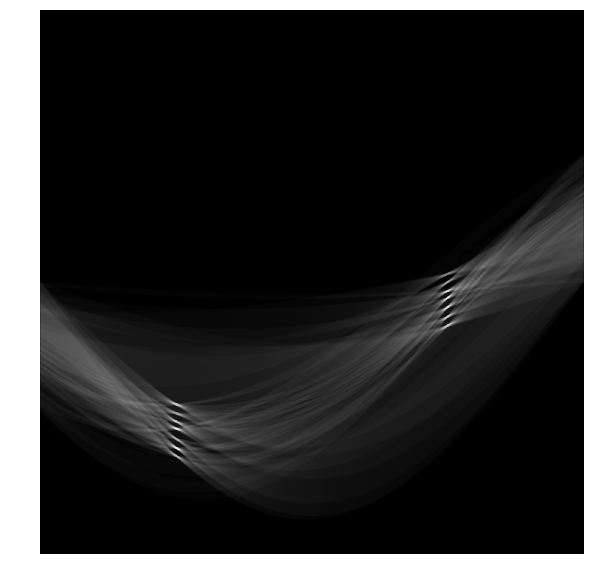

CPU times: user 47.4 s, sys: 233 ms, total: 47.6 s
Wall time: 47.4 s


In [35]:
%%time
im_kernel1 = func_conv(im_hough,func_kernel1)
imshow(im_kernel1)

Threshold: 125.36000061035156 Peaks or Lines: 4802


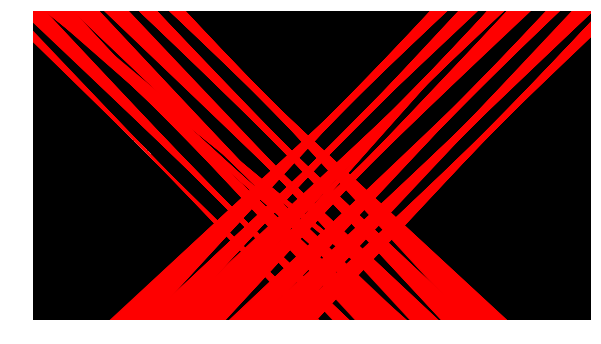

CPU times: user 18.8 s, sys: 212 ms, total: 19 s
Wall time: 18.8 s


In [92]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel1, o_list, r_list)
plot_lines(im_gray,dists,angles)

### 3.2 -  Kernel 2 (Gaussian)

$A = \begin{bmatrix}0.0625\\0.25\\0.375\\0.25\\0.0625 \end{bmatrix} \ \ \ \ \
K = A.A^T = \begin{bmatrix}  0.0039&0.0156&0.0234&0.0156&0.0039 \\ 0.0156&0.0625&0.0937&0.0625&0.0156 \\ 0.0234&0.0937&0.1406&0.0937&0.0234 \\ 0.0156&0.0625&0.0937&0.0625&0.0156 \\ 0.0039&0.0156&0.0234&0.0156&0.0039  \end{bmatrix}$

In [64]:
def func_kernel2(im,sigma=-1):
    
    #kernel 1D
    gaus1D_1 = cv2.getGaussianKernel(im.shape[0],sigma)
    gaus1D_2 = cv2.getGaussianKernel(im.shape[1],sigma)
    
    #kernel 2D
    gaus2D = np.dot(gaus1D_1,gaus1D_2.T)

    return np.sum(im*gaus2D)

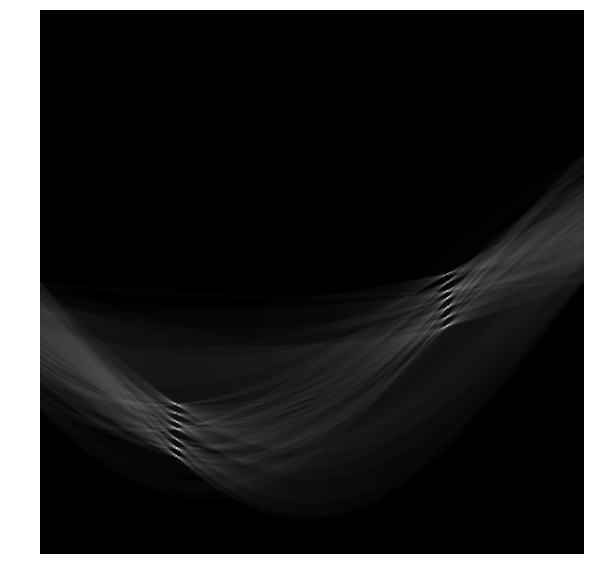

CPU times: user 59.5 s, sys: 276 ms, total: 59.8 s
Wall time: 59.6 s


In [65]:
%%time
im_kernel2 = func_conv(im_hough,func_kernel2)
imshow(im_kernel2)

Threshold: 172.650390625 Peaks or Lines: 1782


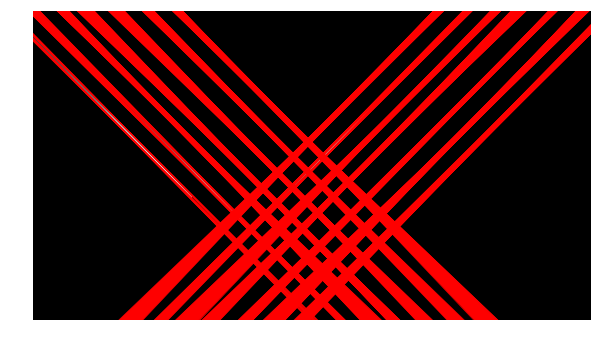

CPU times: user 6.44 s, sys: 156 ms, total: 6.59 s
Wall time: 6.38 s


In [93]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel2, o_list, r_list)
plot_lines(im_gray,dists,angles)

### 3.3 -  Kernel 3 (Custom)

In [66]:
def kernel3(im,kernel):
    out = np.sum(im*kernel)
    return out

In [87]:
kernel = [[ 0, 0, 0, 0, 0],
          [ 0, 0, 0, 0, 0],
          [ 1, 1, 1, 1, 1],
          [ 0, 0, 0, 0, 0],
          [ 0, 0, 0, 0, 0]]
kernel = np.array(kernel)/np.sum(kernel)

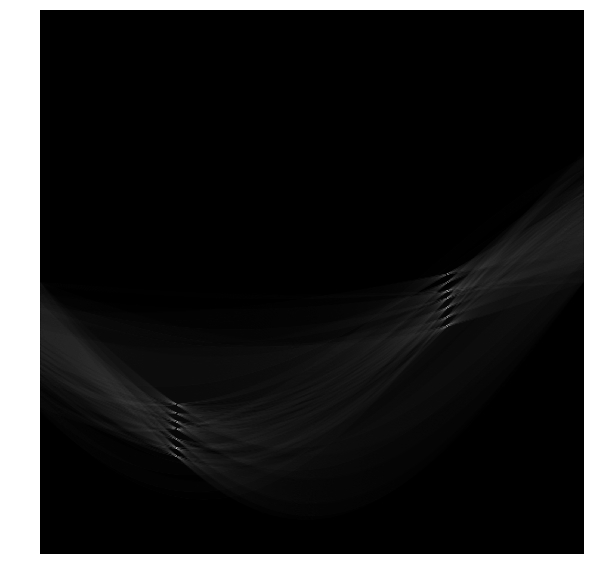

CPU times: user 32.4 s, sys: 260 ms, total: 32.7 s
Wall time: 32.5 s


In [88]:
%%time
im_kernel3 = func_conv(im_hough,kernel3,kernel.shape,(1,1),kernel)
imshow(im_kernel3)

Threshold: 300.0 Peaks or Lines: 208


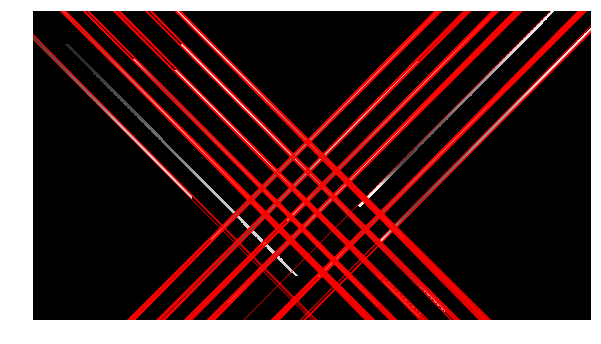

CPU times: user 1.84 s, sys: 176 ms, total: 2.01 s
Wall time: 1.79 s


In [94]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel3, o_list, r_list)
plot_lines(im_gray,dists,angles)